In [ ]:
# Import modules
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from fi_forecasting.core.project_root import get_project_root
# Add project root to path
project_root = get_project_root()
sys.path.append(project_root)

# Import your loader and preprocessing functions
from fi_forecasting.data.loader import load_raw_data, load_reference_codes
from fi_forecasting.data.preprocessing import clean_fi_data, add_growth_rate

# -------------------------
# Load enriched datasets
# -------------------------
enriched_data_path = "../data/processed/enriched_fi_data.csv"
enriched_impact_path = "../data/processed/enriched_impact_links.csv"

fi_df = pd.read_csv(enriched_data_path, parse_dates=['observation_date'])
impact_df = pd.read_csv(enriched_impact_path, parse_dates=['observation_date'])

# -------------------------
# Clean the main dataset
# -------------------------
fi_df = clean_fi_data(fi_df)

# Quick check
print(fi_df.shape)
print(fi_df['record_type'].value_counts())


(45, 34)
record_type
observation    31
event          11
target          3
Name: count, dtype: int64


In [3]:
# Temporal coverage
obs_dates = fi_df.loc[fi_df['record_type']=='observation', 'observation_date']
print(f"Observations range: {obs_dates.min()} → {obs_dates.max()}")

# Counts by pillar, source_type, confidence
print(fi_df['pillar'].value_counts())
print(fi_df['source_type'].value_counts())
print(fi_df['confidence'].value_counts())

# Unique indicators
print(fi_df['indicator_code'].unique())


Observations range: 2014-12-31 00:00:00 → 2025-12-31 00:00:00
pillar
ACCESS           17
USAGE            11
unknown          11
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64
source_type
operator      15
survey        10
regulator      7
research       4
policy         3
calculated     2
news           2
Name: count, dtype: int64
confidence
high      41
medium     3
Name: count, dtype: int64
<StringArray>
[           'ACC_OWNERSHIP',           'ACC_MM_ACCOUNT',
               'ACC_4G_COV',           'ACC_MOBILE_PEN',
                'ACC_FAYDA',            'USG_P2P_COUNT',
            'USG_P2P_VALUE',            'USG_ATM_COUNT',
            'USG_ATM_VALUE',            'USG_CROSSOVER',
       'USG_TELEBIRR_USERS',       'USG_TELEBIRR_VALUE',
          'USG_MPESA_USERS',         'USG_MPESA_ACTIVE',
          'USG_ACTIVE_RATE',          'AFF_DATA_INCOME',
              'GEN_GAP_ACC',             'GEN_MM_SHARE',
           'GEN_GAP_MOBILE',             'EVT_TELEBIRR',
 

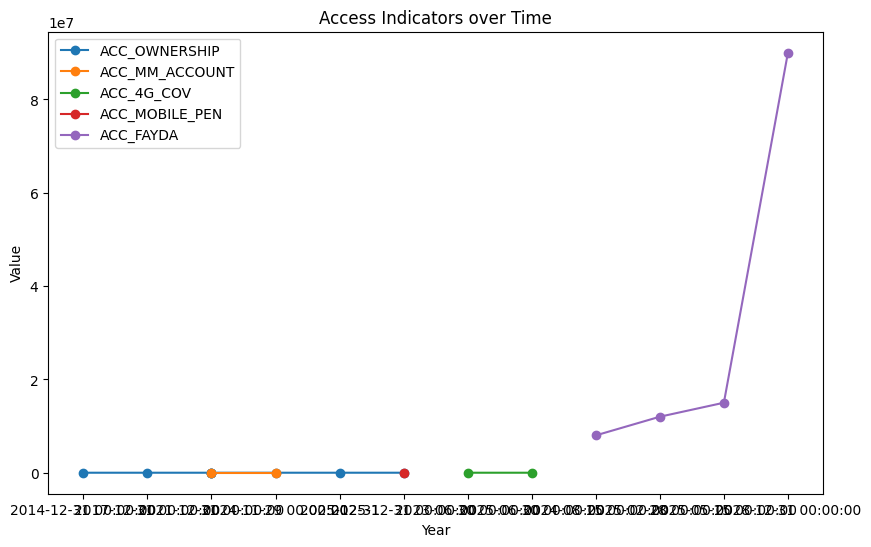

In [4]:
# Filter Access indicators
access_indicators = ['ACC_OWNERSHIP', 'ACC_MM_ACCOUNT', 'ACC_4G_COV', 'ACC_MOBILE_PEN', 'ACC_FAYDA']
access_df = fi_df[fi_df['indicator_code'].isin(access_indicators)]

# Plot Access over time
plt.figure(figsize=(10,6))
for ind in access_indicators:
    sub = access_df[access_df['indicator_code']==ind].sort_values('observation_date')
    plt.plot(sub['observation_date'], sub['value_numeric'], marker='o', label=ind)
plt.title("Access Indicators over Time")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()

# Compute growth rates
for ind in access_indicators:
    fi_df = add_growth_rate(fi_df, ind)


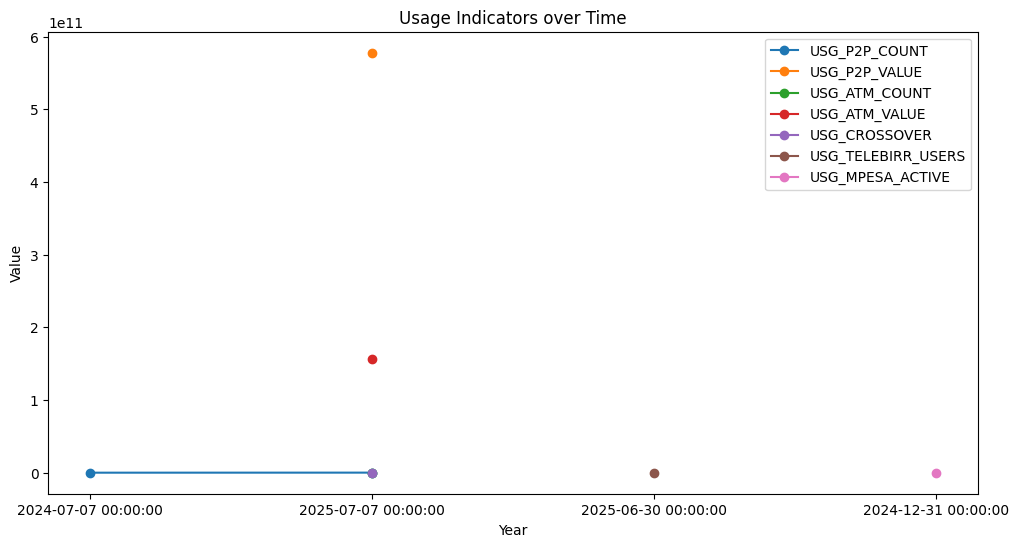

In [5]:
usage_indicators = ['USG_P2P_COUNT','USG_P2P_VALUE','USG_ATM_COUNT','USG_ATM_VALUE','USG_CROSSOVER','USG_TELEBIRR_USERS','USG_MPESA_ACTIVE']
usage_df = fi_df[fi_df['indicator_code'].isin(usage_indicators)]

plt.figure(figsize=(12,6))
for ind in usage_indicators:
    sub = usage_df[usage_df['indicator_code']==ind].sort_values('observation_date')
    plt.plot(sub['observation_date'], sub['value_numeric'], marker='o', label=ind)
plt.title("Usage Indicators over Time")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()


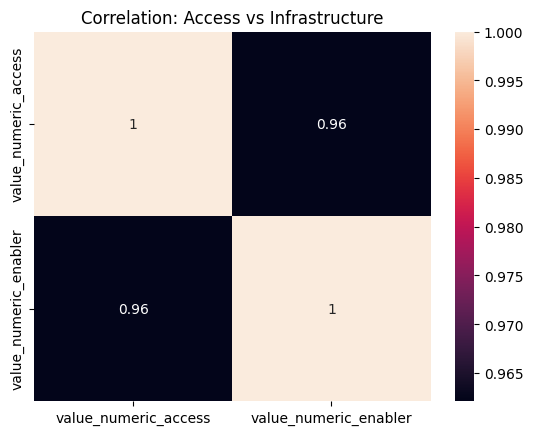

In [6]:
enabler_indicators = ['ACC_4G_COV','ACC_MOBILE_PEN']
enabler_df = fi_df[fi_df['indicator_code'].isin(enabler_indicators)]

# Correlation with Access
corr_df = access_df.merge(enabler_df, on='observation_date', suffixes=('_access','_enabler'))
corr_matrix = corr_df[['value_numeric_access','value_numeric_enabler']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation: Access vs Infrastructure")
plt.show()


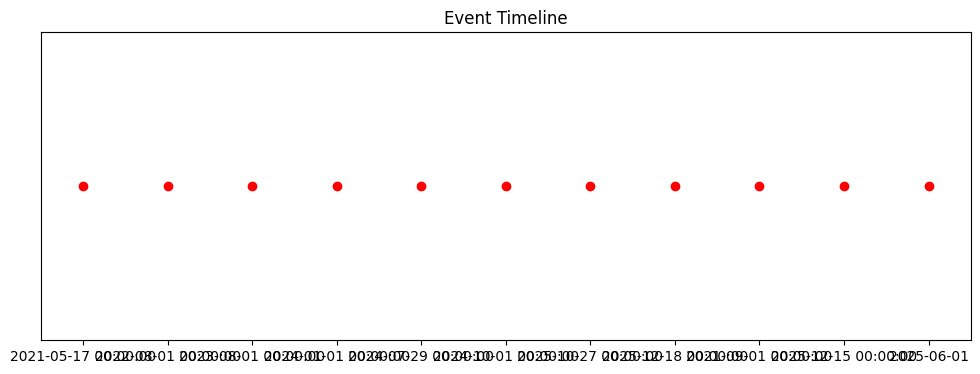

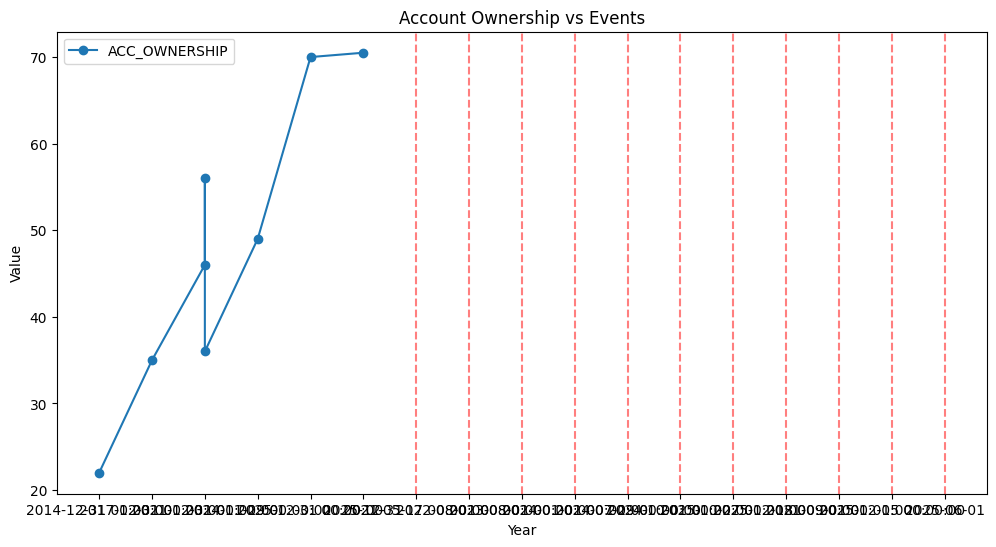

In [7]:
# Extract events
events_df = fi_df[fi_df['record_type']=='event']

plt.figure(figsize=(12,4))
plt.scatter(events_df['observation_date'], [1]*len(events_df), c='red', label='Events')
plt.yticks([])
plt.title("Event Timeline")
plt.show()

# Overlay events on ACC_OWNERSHIP trend
acc_df = fi_df[fi_df['indicator_code']=='ACC_OWNERSHIP']
plt.figure(figsize=(12,6))
plt.plot(acc_df['observation_date'], acc_df['value_numeric'], marker='o', label='ACC_OWNERSHIP')
for idx,row in events_df.iterrows():
    plt.axvline(row['observation_date'], color='red', linestyle='--', alpha=0.5)
plt.title("Account Ownership vs Events")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.show()


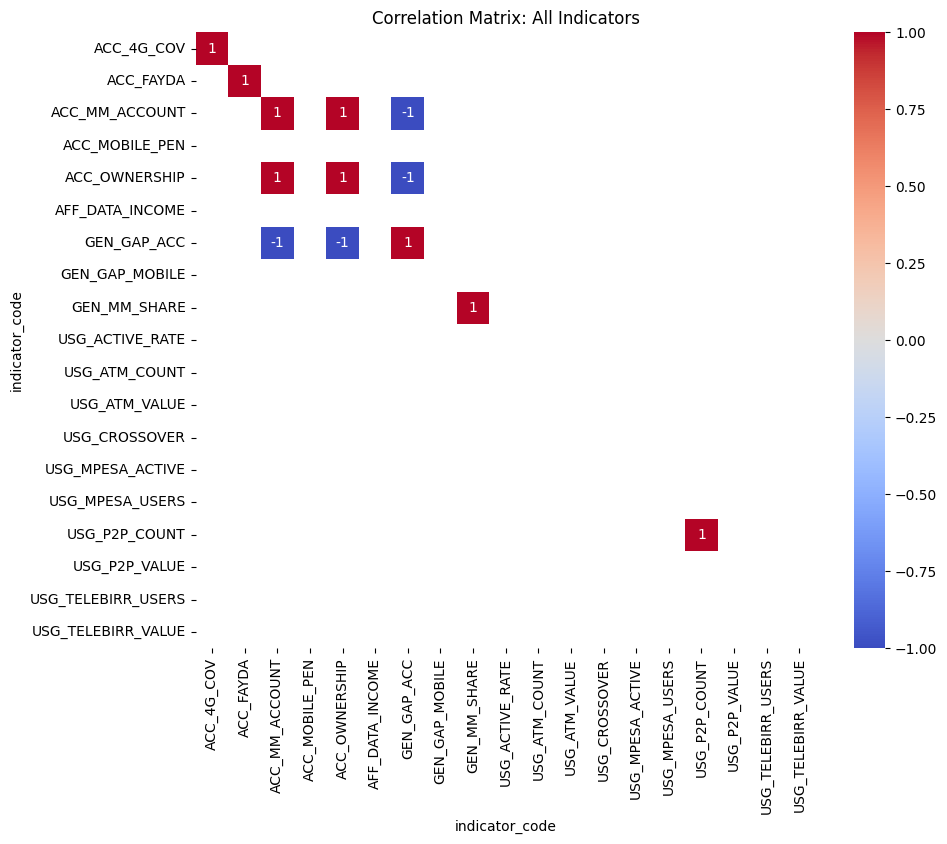

In [8]:
# Create pivot table: dates vs indicators
pivot_df = fi_df.pivot_table(index='observation_date', columns='indicator_code', values='value_numeric')
corr = pivot_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix: All Indicators")
plt.show()
